In [11]:
import numpy as np
import pyaudio
import time
import os
import os.path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cicsim as cs
import matplotlib.pyplot as plt

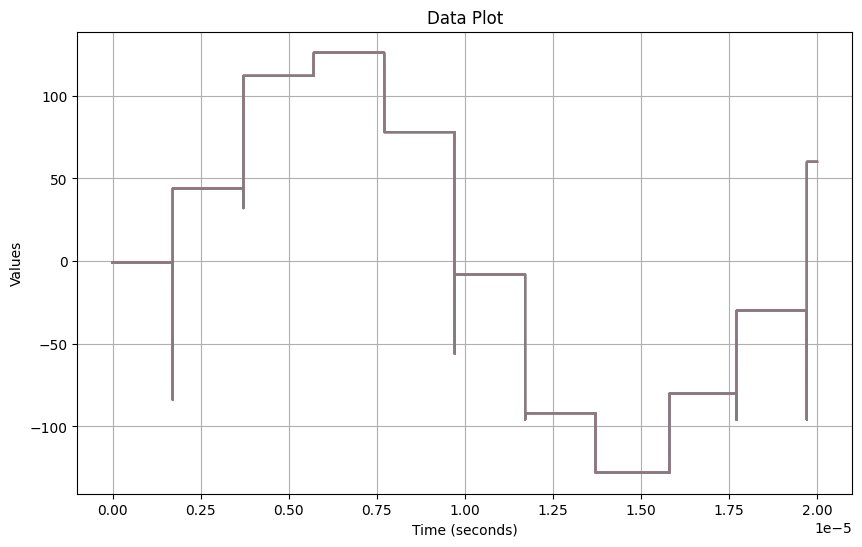

In [12]:
# Load the text file
data = np.loadtxt("/home/mthudaa/vlsi/8bit_SAR-ADC_ITS/xschem/simulations/adc8b_tb.txt")

# Extract columns
time = data[:, 0]  # First column as x-axis (time in seconds)
y_data = np.where(data[:, 2:] > 0.9, 1, 0)  # All other columns as y-axis

# Convert binary data (columns 2 to 10) to decimal
decimal_values = np.array([int("".join(map(str, row)), 2) for row in y_data[:, :9]]) - 128.0

# Combine time and decimal value
processed_data = np.column_stack((time, decimal_values))

# Plot each y-column against time
plt.figure(figsize=(10, 6))
for i in range(y_data.shape[1]):  # Loop through each y-column
    plt.plot(time, decimal_values, label=f'Column {i+2}')  # i+2 because col 1 is time

# Labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Values")
plt.title("Data Plot")
plt.grid()

# Show plot
plt.show()

In [ ]:
processed_data[:,0].shape

(27040,)

In [9]:
nbpt = 2**10
fs = 208333.3333
fin = (0.49)*fs
fbin = int(fin/fs*nbpt)
if(fbin % 2 == 0):
    fbin = fbin + 1
fin = fbin*fs/nbpt
duration = nbpt/fs
print(fin,fbin,fs,nbpt,duration)

101928.7109211914 501 208333.3333 1024 0.004915200000786432


STD 83.2795380150065
MEAN 2.8133505917159765


TypeError: can only concatenate list (not "int") to list

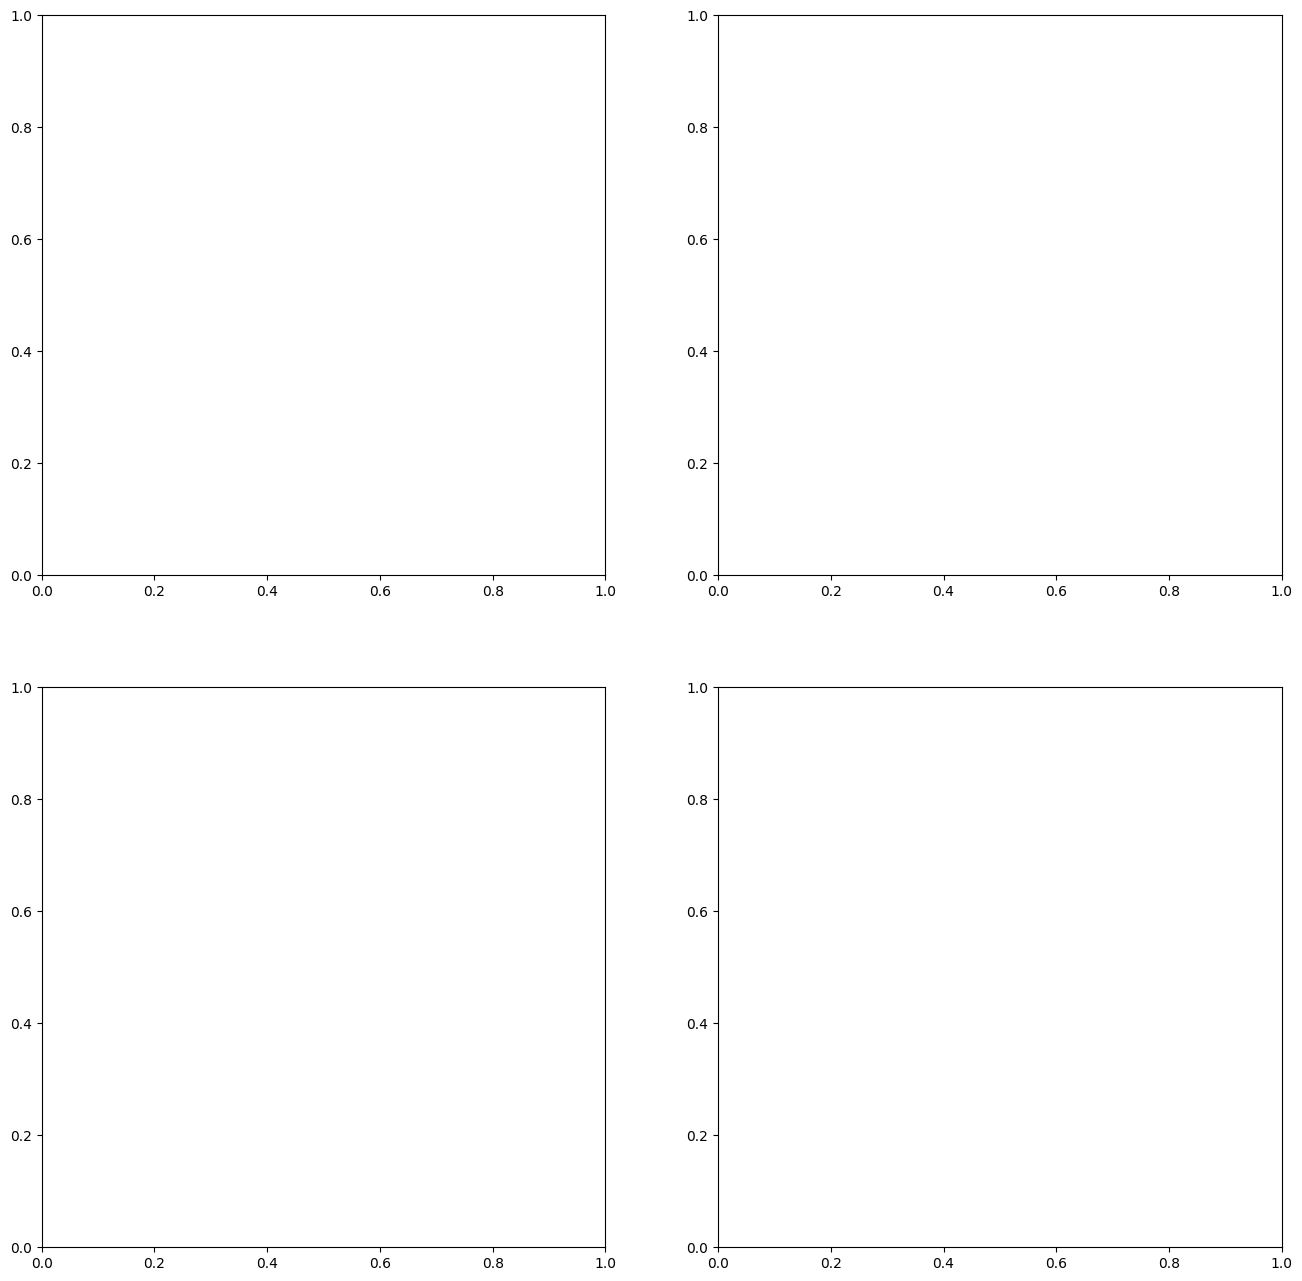

In [ ]:
def toTwosComplement(data):
        if(data > 127):
            data = data - 256
        return data

def paramToStr(data):
    return "A[dB]=%.2f SNDR[dB]=%.2f SNDR[dBFS]=%.2f\nSFDR[dBc]=%.2f ENOB=%.2f ENOBFS=%.2f NBPT=%d" %(data["amp"],data["sndr"],data["sndrfs"],data["sfdr"],data["enob"],data["enobfs"],data["nbpt"])

def inlDnl(y):
     
    # Adapted from Boris Murmann, 2002, inldnl matlab script


    # histogram boundaries
    minbin=min(y)
    maxbin=max(y)
    numbins=maxbin-minbin+1

    # histogram
    h= np.histogram(y, bins=numbins, range=(minbin,maxbin))[0]
    # cumulative histogram
    ch= np.cumsum(h)

    # transition levels
    T = -np.cos(np.pi*ch/sum(h))
    
    #linearized histogram
    hlin = T[2:] - T[1:len(T)-1]

    # truncate at least first and last bin, more if input did not clip ADC
    trunc=2;
    hlin_trunc = hlin[1+trunc:len(hlin)-trunc]

    # calculate lsb size and dnl
    lsb= np.sum(hlin_trunc) / (len(hlin_trunc))
    dnl= [0] + hlin_trunc/lsb-1
    #misscodes = length(find(dnl<-0.9));

    # calculate inl
    inl= np.cumsum(dnl)
    return dnl,inl
     

def plotFFT(data_in,fs):
    df4 = pd.DataFrame(data_in, columns=["Time", "Value"])
    df4["val"] = df4["Value"]
    df4["time"] = df4["Time"]
    df4.set_index("time",inplace=True)
    df4.index = pd.to_datetime(df4.index,unit='s')

    fig,ax = plt.subplots(2,2,figsize=(16,16))
    scc = cs.SimCalc()
    y = df4["val"]/128
    print("STD",df4["val"].std())
    print("MEAN",df4["val"].mean())
    (data,ydB)   = scc.fftWithHanning(y.to_numpy())
    f = np.linspace(0,0.5,num=int(len(ydB)))*fs/1e3
    #ax[0].semilogx(f,ydB,label=paramToStr(data),color="red")
    ax[1][0].semilogx(f,ydB,label=paramToStr(data),color="red")
    ax[1][0].set_ylabel("Magnitude [dBFS]")
    ax[1][0].set_xlabel("Frequency [KHz]")
    ax[1][0].set_ylim(-120,0)
    ax[1][0].legend()
    ax[0][0].plot(f,ydB,label=paramToStr(data),color="red")
    ax[0][0].set_ylabel("Magnitude [dBFS]")
    ax[0][0].set_xlabel("Frequency [KHz]")
    ax[0][0].set_ylim(-120,0)
    ax[0][0].legend()
    t = np.linspace(0,len(y),num=len(y))/fs
    ax[0][1].plot(t,y,marker=".",linestyle="-",color="red",markersize=1)
    ax[0][1].set_ylim(-1,1)
    ax[0][1].set_ylabel("Normalized Output")
    ax[0][1].set_xlabel("Time [s]")
    #ax[1][1].hist(y,bins=256)
    (dnl,inl)= inlDnl(df4["val"])
    ax[1][1].plot(dnl,label="DNL",color="blue")
    ax[1][1].plot(inl,label="INL",color="red")
    ax[1][1].legend()
    #ax[1][1].set_ylabel("DNL")
    ax[1][1].set_xlabel("Code")
    #ax[1][1].set_ylim(,0.5)
    ax[1][1].set_xlim(0,255)
    
    #ax[1].set_ylim(-0.25,0.25)
    #ax[1].set_xlim(0.0005,0.001)
    #ax[1].set_xlim(0.1,0.2)
    # plt.savefig(fcapture.replace(".csv",".png"))
    plt.show()
    plt.tight_layout()
plotFFT(processed_data,fs)
    